## 仓位管理-pyramid

1. 金字塔加仓法


2. 金字塔加仓法优化

## 1.金字塔加仓法
 金字塔加仓法是一种逐级加仓模式，其加仓数量与盈利(亏损)幅度成反比，加仓手数如图，图中数值分别为每次加仓手数占总仓位百分比：
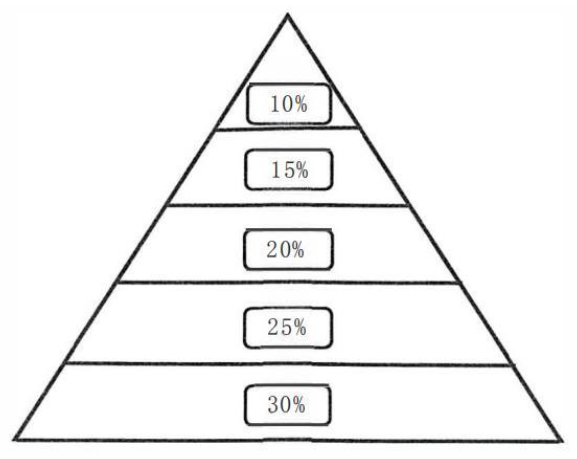

 见 onBar ‘金字塔加仓模块’以及on30MinBar‘进出场逻辑模块’
 
 用参数 n 控制加仓次数，参数 Ratio 控制加仓的进场位置，参数fixsize控制最大仓位手数
 
 则第一次开仓到第五次加满仓的手数分别为fixsize*0.3,fixsize*0.25,fixsize*0.20,fixsize*0.15,fixsize*0.10
 
### 算法如下：
if 持多头仓位 and 当前加仓次数 nPos < 3：

    if 亏损达到Ratio/100：
        nPos = nPos+1

        加仓fixsize*(0.3-0.05*nPos)手数
        

elif 持空头仓位 and 当前加仓次数 nPos < 3：

    if 亏损达到Ratio：
        nPos = nPos+1

        加仓fixsize*(0.3-0.05*nPos)手数
        

### 当执行平仓信号，将 nPos 重置为 0 

if 持有多头仓位 and 死叉：

    nPos = 0
    
elif 持有空头仓位 and 金叉：

    nPos = 0

In [ ]:
## 大的价格除以小的价格减1
lastOrder=self.transactionPrice[symbol]
## 多头亏损大于一个百分比
(self.transactionPrice[symbol] - bar.close)/bar.close
= lastOrder/bar.close-1

## 多头盈利大于一个百分比
(bar.close-self.transactionPrice[symbol])/self.transactionPrice[symbol]
= bar.close/lastOrder-1

## 空头亏损大于一个百分比
(bar.close - self.transactionPrice[symbol])/self.transactionPrice[symbol]
= bar.close/lastOrder-1

## 空头盈利大于一个百分比
(self.transactionPrice[symbol] - bar.close)/bar.close
= lastOrder/bar.close-1

In [ ]:
# 设置参数    
    nPos = 0
    fixsize = 100
    transactionPrice = {}
    Ratio = 0.02
# 设置变量    
    self.transactionPrice = {s: 0 for s in self.symbolList}
    
    #----------------------------------------------------------------------
    def onBar(self, bar):
        """收到Bar推送"""
        symbol = bar.vtSymbol
        lastOrder=self.transactionPrice[symbol]        
        # 金字塔加仓模块______________________________________
        if (self.posDict[symbol+'_LONG']!=0 and self.nPos < 3):    # 持有多头仓位并且加仓次数不超过3次
            if bar.close/lastOrder-1>= self.Ratio:   # 计算盈利比例,达到2%
                self.nPos += 1  # 加仓次数减少 1 次
                self.buy(symbol,bar.close*1.02,self.fixsize*(0.3-0.05*self.nPos))  # 目标仓位100手，分别加仓25手、20手、15手，10手
                
        elif (self.posDict[symbol + "_SHORT"] != 0 and self.nPos < 3):    # 持有空头仓位并且加仓次数不超过3次
            if lastOrder/bar.close-1 >= self.Ratio:   # 计算盈利比例,达到2%
                self.nPos += 1  # 加仓次数减少 1 次
                self.short(symbol,bar.close*0.98,self.fixsize*(0.3-0.05*self.nPos))  # 目标仓位100手，分别加仓25手、20手、15手，10手
                
        
        # 发出状态更新事件
        self.putEvent()
        
    def on30MinBar(self, bar):
        """30分钟K线推送"""
        symbol = bar.vtSymbol
    
        am30 = self.getArrayManager(symbol, "30m")

        if not am30.inited:
            return
        
        # 计算策略需要的信号-------------------------------------------------
        fastMa = ta.EMA(am30.close, self.fastWindow)        
        slowMa = ta.EMA(am30.close, self.slowWindow)

        crossOver = fastMa[-1]>slowMa[-1] and fastMa[-2]<=slowMa[-2]     # 金叉上穿
        crossBelow = fastMa[-1]<slowMa[-1] and fastMa[-2]>=slowMa[-2]   # 死叉下穿
        
        if crossOver:
            print('crossOver:',crossOver)
        elif crossBelow:
            print('crossBelow:',crossBelow)
        
        # 构建进出场逻辑-------------------------------------------------
        # 金叉和死叉的条件是互斥
        if crossOver:
            # 如果金叉时手头没有持仓，则直接做多
            if (self.posDict[symbol+'_LONG']==0) and (self.posDict[symbol+'_SHORT']==0):
                self.buy(symbol, bar.close*1.02, self.fixsize*0.3)
            # 如果有空头持仓，则先平空，再做多
            elif self.posDict[symbol+'_SHORT'] >0:
                self.cancelAll()
                self.cover(symbol,bar.close*1.02, self.posDict[symbol+'_SHORT'])
                self.nPos = 0
                self.buy(symbol,bar.close*1.02, self.fixsize*0.3)

        # 死叉和金叉相反
        elif crossBelow :
            if (self.posDict[symbol+'_LONG']==0) and (self.posDict[symbol+'_SHORT']==0):
                self.short(symbol,bar.close*0.98, self.fixsize*0.3)
            elif self.posDict[symbol+'_LONG'] >0:
                self.cancelAll()
                self.sell(symbol,bar.close*0.98, self.posDict[symbol+'_LONG'])
                self.nPos = 0
                self.short(symbol,bar.close*0.98, self.fixsize*0.3)
        
        # 发出状态更新事件
        self.putEvent()

### 金字塔加仓法案例

In [3]:
"""
这里的Demo是一个最简单的双均线策略实现
"""

from __future__ import division
from vnpy.trader.vtConstant import *
from vnpy.trader.app.ctaStrategy.ctaBarManager import CtaTemplate
import numpy as np
import talib as ta
from datetime import timedelta

########################################################################
# 策略继承CtaTemplate
class DoubleMaStrategy(CtaTemplate):
    """双指数均线策略Demo"""
    className = 'DoubleMaStrategy'
    author = 'ChannelCMT'
    
    # 策略参数
    barPeriod = 200
    fastWindow = 60     # 快速均线参数
    slowWindow = 120     # 慢速均线参数
    
    # 参数列表，保存了参数的名称
    paramList = ['name',
                 'className',
                 'author',
                 'fastWindow',
                 'slowWindow']    
    
    # 变量列表，保存了变量的名称
    varList = ['barPeriod']  
    nPos = 0
    fixsize = 100
    transactionPrice = {}
    Ratio = 0.02
    # 同步列表，保存了需要保存到数据库的变量名称
    syncList = ['posDict', 'eveningDict']

    #----------------------------------------------------------------------
    def __init__(self, ctaEngine, setting):
        # 首先找到策略的父类（就是类CtaTemplate），然后把DoubleMaStrategy的对象转换为类CtaTemplate的对象
        super().__init__(ctaEngine, setting)
      
    #----------------------------------------------------------------------
    def onInit(self):
        """初始化策略（必须由用户继承实现）"""
        self.writeCtaLog(u'双EMA演示策略初始化')
        
        # 生成Bar数组
        self.setArrayManagerSize(self.barPeriod)
        self.transactionPrice = {s: 0 for s in self.symbolList}


        self.mail("chushihuaaaaaaaaaaaaaaaaaaaaaaaaa")
        self.putEvent()

    #----------------------------------------------------------------------
    def onStart(self):
        """启动策略（必须由用户继承实现）"""
        self.writeCtaLog(u'双EMA演示策略启动')
        self.putEvent()
    
    #----------------------------------------------------------------------
    def onStop(self):
        """停止策略（必须由用户继承实现）"""
        self.writeCtaLog(u'策略停止')
        self.putEvent()
        
    #----------------------------------------------------------------------
    def onTick(self, tick):
        """收到行情TICK推送（必须由用户继承实现）"""
        pass
        
    #----------------------------------------------------------------------
    def onBar(self, bar):
        """收到Bar推送"""
        symbol = bar.vtSymbol
        lastOrder=self.transactionPrice[symbol]        
        # 金字塔加仓模块______________________________________
        if (self.posDict[symbol+'_LONG']!=0 and self.nPos < 3):    # 持有多头仓位并且加仓次数不超过3次
            if bar.close/lastOrder-1>= self.Ratio:   # 计算盈利比例,达到2%
                self.nPos += 1  # 加仓次数减少 1 次
                self.buy(symbol,bar.close*1.02,self.fixsize*(0.3-0.05*self.nPos))  # 目标仓位100手，分别加仓25手、20手、15手，10手
                
        elif (self.posDict[symbol + "_SHORT"] != 0 and self.nPos < 3):    # 持有空头仓位并且加仓次数不超过3次
            if lastOrder/bar.close-1 >= self.Ratio:   # 计算盈利比例,达到2%
                self.nPos += 1  # 加仓次数减少 1 次
                self.short(symbol,bar.close*0.98,self.fixsize*(0.3-0.05*self.nPos))  # 目标仓位100手，分别加仓25手、20手、15手，10手
                
        
        # 发出状态更新事件
        self.putEvent()
        
    def on30MinBar(self, bar):
        """30分钟K线推送"""
        symbol = bar.vtSymbol
    
        am30 = self.getArrayManager(symbol, "30m")

        if not am30.inited:
            return
        
        # 计算策略需要的信号-------------------------------------------------
        fastMa = ta.EMA(am30.close, self.fastWindow)        
        slowMa = ta.EMA(am30.close, self.slowWindow)

        crossOver = fastMa[-1]>slowMa[-1] and fastMa[-2]<=slowMa[-2]     # 金叉上穿
        crossBelow = fastMa[-1]<slowMa[-1] and fastMa[-2]>=slowMa[-2]   # 死叉下穿
        
        if crossOver:
            print('crossOver:',crossOver)
        elif crossBelow:
            print('crossBelow:',crossBelow)
        
        # 构建进出场逻辑-------------------------------------------------
        # 金叉和死叉的条件是互斥
        if crossOver:
            # 如果金叉时手头没有持仓，则直接做多
            if (self.posDict[symbol+'_LONG']==0) and (self.posDict[symbol+'_SHORT']==0):
                self.buy(symbol, bar.close*1.02, self.fixsize*0.3)
            # 如果有空头持仓，则先平空，再做多
            elif self.posDict[symbol+'_SHORT'] >0:
                self.cancelAll()
                self.cover(symbol,bar.close*1.02, self.posDict[symbol+'_SHORT'])
                self.nPos = 0
                self.buy(symbol,bar.close*1.02, self.fixsize*0.3)

        # 死叉和金叉相反
        elif crossBelow :
            if (self.posDict[symbol+'_LONG']==0) and (self.posDict[symbol+'_SHORT']==0):
                self.short(symbol,bar.close*0.98, self.fixsize*0.3)
            elif self.posDict[symbol+'_LONG'] >0:
                self.cancelAll()
                self.sell(symbol,bar.close*0.98, self.posDict[symbol+'_LONG'])
                self.nPos = 0
                self.short(symbol,bar.close*0.98, self.fixsize*0.3)
        
        # 发出状态更新事件
        self.putEvent()
    #----------------------------------------------------------------------
    def onOrder(self, order):
        """收到委托变化推送（必须由用户继承实现）"""
        # 对于无需做细粒度委托控制的策略，可以忽略onOrder
#         print(u'出现未知订单，需要策略师外部干预,ID:%s, symbol:%s,direction:%s,offset:%s'% (order.vtOrderID, order.vtSymbol, order.direction, order.offset))
        pass
    
    #----------------------------------------------------------------------
    def onTrade(self, trade):
        """收到成交推送（必须由用户继承实现）"""
        symbol = trade.vtSymbol
        self.transactionPrice[symbol] = trade.price
        pass
    
    #----------------------------------------------------------------------
    def onStopOrder(self, so):
        """停止单推送"""
        pass

## 金字塔加仓模型绩效测试

仓位字典构造完成 
初始仓位: {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 0}
[DEBUG] 注册品种BTCUSDT:binance上的on_1m_bar函数functools.partial(<function DoubleMaStrategy.onBar at 0x00000118CB45B950>, <__main__.DoubleMaStrategy object at 0x00000118CD017D30>)
[DEBUG] 注册品种BTCUSDT:binance上的on_30Min_bar函数functools.partial(<function DoubleMaStrategy.on30MinBar at 0x00000118CB45BD08>, <__main__.DoubleMaStrategy object at 0x00000118CD017D30>)
2018-11-15 17:06:41.832246	开始回测
2018-11-15 17:06:41.832246	策略初始化
2018-11-15 17:06:41.836243	载入历史数据。数据范围:[20180923 04:00,20181001 12:00)
2018-11-15 17:07:14.229587	失去MongoDB的连接，我们尝试使用本地缓存数据，请注意数据量
2018-11-15 17:07:14.242545	载入完成，数据量：12000
2018-11-15 17:07:14.242545	策略初始化完成
2018-11-15 17:07:14.242545	策略启动完成
2018-11-15 17:07:14.244542	开始回放回测数据,回测范围:[20181001 12:00,20181031 16:00)
2018-11-15 17:07:14.256535	载入历史数据。数据范围:[20181001 12:00,20181031 16:00)
2018-11-15 17:07:52.528401	失去MongoDB的连接，我们尝试使用本地缓存数据，请注意数据量
2018-11-15 17:07:52.564347	载入完成，数据量：43230
2018-11-15 17:07:52.5

D:\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.13.dev181104-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py:1287: RuntimeWarning: invalid value encountered in log
  df['return'] = (np.log(df['balance']) - np.log(df['balance'].shift(1))).fillna(0)


2018-11-15 17:09:15.731470	策略回测绩效图已保存


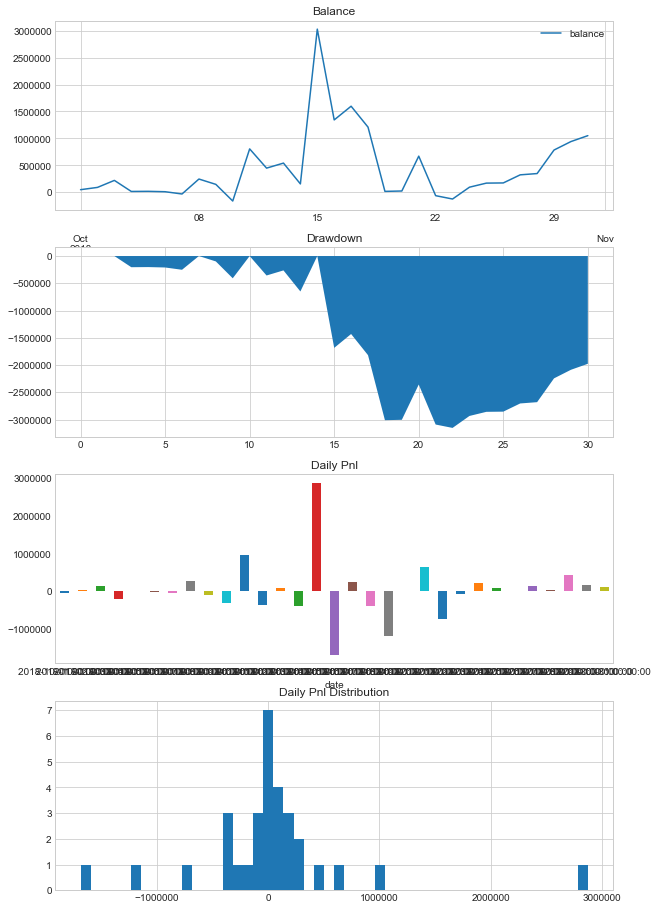

2018-11-15 17:09:16.499001	计算回测结果
2018-11-15 17:09:16.507002	交割单已生成
2018-11-15 17:09:16.507992	------------------------------
2018-11-15 17:09:16.507992	第一笔交易：	2018-10-04 22:30:00
2018-11-15 17:09:16.507992	最后一笔交易：	2018-10-31 15:58:00
2018-11-15 17:09:16.507992	总交易次数：	14
2018-11-15 17:09:16.507992	总盈亏：	934,175.86
2018-11-15 17:09:16.507992	最大回撤: 	-570,710.25
2018-11-15 17:09:16.507992	平均每笔盈利：	66,726.85
2018-11-15 17:09:16.507992	平均每笔滑点：	0.0
2018-11-15 17:09:16.507992	平均每笔佣金：	15,843.15
2018-11-15 17:09:16.507992	胜率		50.0%
2018-11-15 17:09:16.507992	盈利交易平均值	320,543.11
2018-11-15 17:09:16.507992	亏损交易平均值	-187,089.42
2018-11-15 17:09:16.507992	盈亏比：	1.71
2018-11-15 17:09:17.148822	策略回测统计图已保存


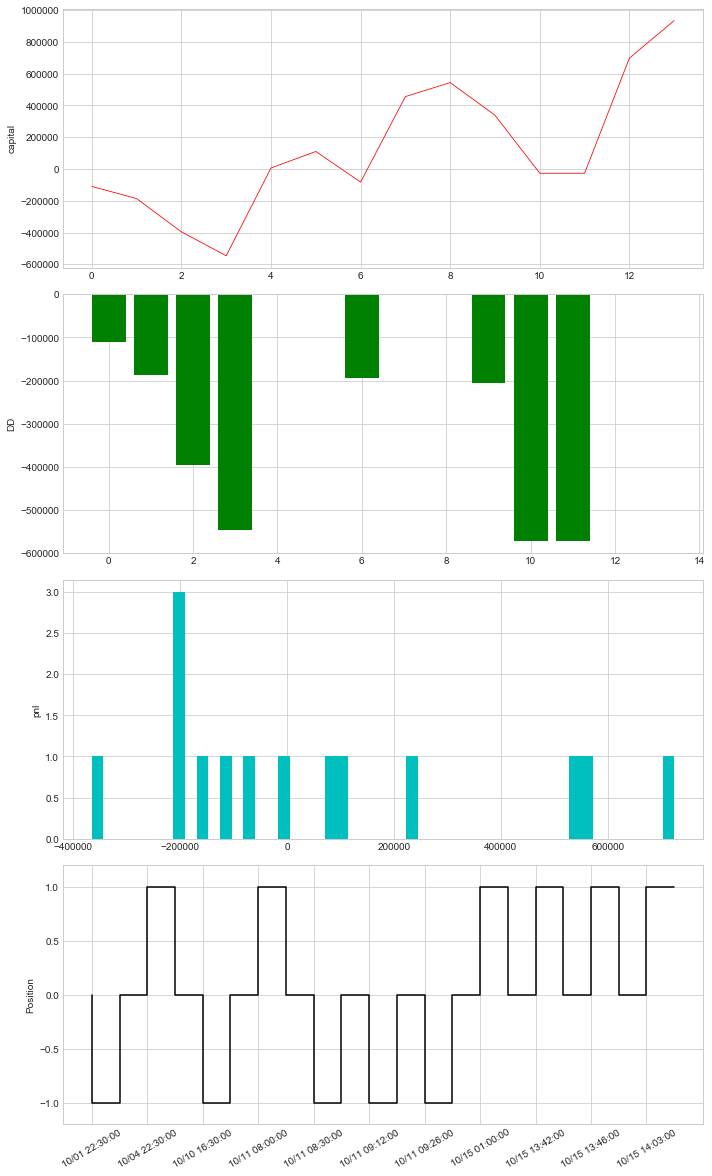

2018-11-15 17:09:17.684494	计算按日统计结果


In [4]:
from vnpy.trader.app.ctaStrategy.ctaBarManager import BacktestingEngine
import pandas as pd

def runBacktesting(strategyClass, settingDict,
                   startDate, endDate, size, slippage, rate):
    engine = BacktestingEngine()
    engine.setBacktestingMode(engine.BAR_MODE)
    engine.setDatabase('VnTrader_1Min_Db')
    engine.setStartDate(startDate, initHours=200)
    engine.setEndDate(endDate)
    engine.setSize(size)
    engine.setSlippage(slippage)
    engine.setRate(rate)
    engine.initStrategy(strategyClass, settingDict)
    engine.setCapital(100000)
    engine.setLog(True, 'E://log//')
    engine.runBacktesting()
    #显示逐日回测结果
    engine.showDailyResult()
    #显示逐笔回测结果
    engine.showBacktestingResult()
    # 计算回测结果
    perfromance = engine.calculateDailyResult()
    perfromanceDf , result = engine.calculateDailyStatistics(perfromance)
    tradeReport = pd.DataFrame([obj.__dict__ for obj in engine.tradeDict.values()])
    tradeDf = tradeReport.set_index('dt')
    return perfromanceDf, tradeDf

if __name__ == '__main__':
    # 同时传入信号与执行的数据
    performanceReport, tradeReport = \
        runBacktesting(DoubleMaStrategy, {'symbolList': ['BTCUSDT:binance']},
                       '20181001 12:00', '20181031 16:00', 100, 0, 5/10000)
    # tradeReport.to_excel('BBandMa5MinStrategyReport.xlsx')

## 交易信息

In [5]:
tradeReport

,direction,exchange,exchangeOrderID,fee,gatewayName,offset,orderID,orderTime,price,price_avg,rawData,status,symbol,tradeID,tradeTime,volume,vtOrderID,vtSymbol,vtTradeID
dt,,,,,,,,,,,,,,,,,,,
2018-10-01 22:30:00,空,,,0.0,,开仓,1,,6556.00,0.0,None,,,1,2018-10-01 22:30:00,30.0,1,BTCUSDT:binance,1
2018-10-04 22:30:00,多,,,0.0,,平仓,2,,6586.00,0.0,None,,,2,2018-10-04 22:30:00,30.0,2,BTCUSDT:binance,2
2018-10-04 22:30:00,多,,,0.0,,开仓,3,,6586.00,0.0,None,,,3,2018-10-04 22:30:00,30.0,3,BTCUSDT:binance,3
2018-10-10 16:30:00,空,,,0.0,,平仓,4,,6567.03,0.0,None,,,4,2018-10-10 16:30:00,30.0,4,BTCUSDT:binance,4
2018-10-10 16:30:00,空,,,0.0,,开仓,5,,6567.03,0.0,None,,,5,2018-10-10 16:30:00,30.0,5,BTCUSDT:binance,5
2018-10-11 08:00:00,多,,,0.0,,平仓,6,,6630.21,0.0,None,,,6,2018-10-11 08:00:00,30.0,6,BTCUSDT:binance,6
2018-10-11 08:00:00,多,,,0.0,,开仓,7,,6630.21,0.0,None,,,7,2018-10-11 08:00:00,30.0,7,BTCUSDT:binance,7
2018-10-11 08:30:00,空,,,0.0,,平仓,8,,6586.65,0.0,None,,,8,2018-10-11 08:30:00,30.0,8,BTCUSDT:binance,8
2018-10-11 08:30:00,空,,,0.0,,开仓,9,,6586.65,0.0,None,,,9,2018-10-11 08:30:00,30.0,9,BTCUSDT:binance,9


## 2.金字塔加仓法优化
 金字塔加仓法缺点是第一次入场仓位较重，而后加仓手数较轻，则可以适当提高第一次开仓的要求，同时降低后面加仓的要求
 
 见 onBar 和0n30MinBar‘优化金字塔加仓模块’
 
用参数 n 控制加仓次数，参数 Ratio 控制加仓的进场位置，参数fixsize控制最大仓位手数,参数condition和tmp作为临时变量控制加仓逻辑。

### 1.加入更多的开仓条件，开仓算法如下：
if 金叉 and 多头排列：

    开多单，仓位 = fixsize*0.3
    
elif 死叉 and 空头排列：

    开空单，仓位 = fixsize*0.3
    
### 2.加仓依然使用金字塔加仓法，但修改加仓条件，算法如下：
if 持多头仓位 and 股价与短均线死叉：

    tmp = 1
    
elif 持空头仓位 and 股价与短均线金叉：

    tmp = -1
    
if tmp == 1 and 股价与短均线金叉：

    condition = 1
    
elif tmp == -1 and 股价与短均线死叉：

    condition = -1
    
if 持多头仓位 and 当前加仓次数 nPos< 5：

    if 当前处于盈利状态 and condition == 1:
    
        nPos = nPos+1
        
        加仓fixsize*(0.3-0.05*nPos)手数
        
        tmp,condition = 0,0
        

elif 持空头仓位 and 当前加仓次数 nPos< 5：

    if 当前处于盈利状态 and condition == -1:
    
        nPos= nPos+1
        
        加仓fixsize*(0.3-0.05*nPos)手数
        
        tmp,condition = 0,0
### 当执行平仓信号，将 nPos 重置为 0 

if 持有多头仓位 and 死叉：

    nPos = 0
    
elif 持有空头仓位 and 金叉：

    nPos = 0

In [ ]:
# 设置参数        
    nPos = 0
    fixsize = 100
    transactionPrice = {}
    Ratio = 100
    tmp = 0
    condition = 0
    
# 设置变量    
    self.transactionPrice = {s: 0 for s in self.symbolList}
    
    #----------------------------------------------------------------------
    def onBar(self, bar):
        """收到Bar推送（必须由用户继承实现）"""
        symbol = bar.vtSymbol
        
        am = self.getArrayManager(symbol, "1m")

        if not am.inited:
            return
        
        # 优化金字塔加仓模块________________________________________________
        
        if (self.posDict[symbol+'_LONG']!=0 and self.nPos < 5):    # 持有多头仓位并且加仓次数不超过5次
            if self.transactionPrice[symbol]>bar.close and self.condition == 1:   # 当前是盈利状况，并且满足上述加仓条件
                self.nPos += 1  # 加仓次数减少 1 次
                self.buy(symbol,bar.close*1.02,self.fixsize*(0.3-self.nPos*0.05))  # 目标加仓100手  分别为加仓 30手、25手、20手，15手，10手
                self.tmp = 0  # 置零两个临时的控制变量
                self.condition = 0
        elif (self.posDict[symbol + "_SHORT"] != 0 and self.nPos < 5):    # 持有空头仓位并且加仓次数不超过5次
            if bar.close>self.transactionPrice[symbol] and self.condition == -1:   # 当前是盈利状况，并且满足上述加仓条件
                self.nPos += 1  # 加仓次数减少 1 次
                self.short(symbol,bar.close*0.98,self.fixsize*(0.3-self.nPos*0.05))  # 目标加仓100手  分别为加仓 30手、25手、20手，15手，10手
                self.tmp = 0  # 置零两个临时的控制变量
                self.condition = 0
        
        # 发出状态更新事件
        self.putEvent()
        
    def on30MinBar(self, bar):
        """30分钟K线推送"""
        symbol = bar.vtSymbol
    
        am30 = self.getArrayManager(symbol, "30m")

        if not am30.inited:
            return
        
        # 计算策略需要的信号-------------------------------------------------
        fastMa = ta.EMA(am30.close, self.fastWindow)        
        slowMa = ta.EMA(am30.close, self.slowWindow)
        
        # 优化金字塔加仓模块________________________________________________
        price_crossOver = am30.close[-1]>fastMa[-1] and am30.close[-2]<fastMa[-2]   # 估价金叉短均线
        price_crossBelow = am30.close[-1]<fastMa[-1] and am30.close[-2]>fastMa[-2]  # 估价死叉短均线
        
        if self.posDict[symbol+'_LONG']!=0 and price_crossBelow: # 持有多头仓位，并且估价死叉短均线
            self.tmp = 1  # 临时变量，记录死叉现象
        elif self.posDict[symbol + "_SHORT"] != 0 and price_crossOver: # 持有多头仓位，并且估价金叉短均线
            self.tmp = -1  # 临时变量，记录金叉现象
        if self.tmp == 1 and price_crossOver: # 多头持仓中，发生死叉后金叉，即回调后再次上次，满足加仓条件
            self.condition = 1
        elif self.tmp == -1 and price_crossBelow: # 空头持仓中，发生金叉后死叉，即回调后再次下跌，满足加仓条件
            self.condition = -1
        
        

### 金字塔加仓法优化案例

In [15]:
"""
这里的Demo是一个最简单的双均线策略实现
"""

from __future__ import division
from vnpy.trader.vtConstant import *
from vnpy.trader.app.ctaStrategy.ctaBarManager import CtaTemplate
import numpy as np
import talib as ta
from datetime import timedelta

########################################################################
# 策略继承CtaTemplate
class DoubleMaStrategy(CtaTemplate):
    """双指数均线策略Demo"""
    className = 'DoubleMaStrategy'
    author = 'ChannelCMT'
    
    # 策略参数
    barPeriod = 200
    fastWindow = 60     # 快速均线参数
    slowWindow = 120     # 慢速均线参数
    
    # 参数列表，保存了参数的名称
    paramList = ['name',
                 'className',
                 'author',
                 'fastWindow',
                 'slowWindow']    
    
    # 变量列表，保存了变量的名称
    varList = ['barPeriod']  
    nPos = 0
    fixsize = 100
    transactionPrice = {}
    Ratio = 100
    tmp = 0
    condition = 0
    # 同步列表，保存了需要保存到数据库的变量名称
    syncList = ['posDict', 'eveningDict']

    #----------------------------------------------------------------------
    def __init__(self, ctaEngine, setting):
        # 首先找到策略的父类（就是类CtaTemplate），然后把DoubleMaStrategy的对象转换为类CtaTemplate的对象
        super().__init__(ctaEngine, setting)
      
    #----------------------------------------------------------------------
    def onInit(self):
        """初始化策略（必须由用户继承实现）"""
        self.writeCtaLog(u'双EMA演示策略初始化')
        
        # 生成Bar数组
        self.setArrayManagerSize(self.barPeriod)
        self.transactionPrice = {s: 0 for s in self.symbolList}


        self.mail("chushihuaaaaaaaaaaaaaaaaaaaaaaaaa")
        self.putEvent()

    #----------------------------------------------------------------------
    def onStart(self):
        """启动策略（必须由用户继承实现）"""
        self.writeCtaLog(u'双EMA演示策略启动')
        self.putEvent()
    
    #----------------------------------------------------------------------
    def onStop(self):
        """停止策略（必须由用户继承实现）"""
        self.writeCtaLog(u'策略停止')
        self.putEvent()
        
    #----------------------------------------------------------------------
    def onTick(self, tick):
        """收到行情TICK推送（必须由用户继承实现）"""
        pass
        
    #----------------------------------------------------------------------
    def onBar(self, bar):
        """收到Bar推送"""
        symbol = bar.vtSymbol        
        am = self.getArrayManager(symbol, "1m")

        if not am.inited:
            return

        
        # 优化金字塔加仓模块________________________________________________
        
        if (self.posDict[symbol+'_LONG']!=0 and self.nPos < 5):    # 持有多头仓位并且加仓次数不超过5次
            if self.transactionPrice[symbol]>bar.close and self.condition == 1:   # 当前是盈利状况，并且满足上述加仓条件
                self.nPos += 1  # 加仓次数减少 1 次
                self.buy(symbol,bar.close*1.02,self.fixsize*(0.3-self.nPos*0.05))  # 目标加仓100手  分别为加仓 30手、25手、20手，15手，10手
                self.tmp = 0  # 置零两个临时的控制变量
                self.condition = 0
        elif (self.posDict[symbol + "_SHORT"] != 0 and self.nPos < 5):    # 持有空头仓位并且加仓次数不超过5次
            if bar.close>self.transactionPrice[symbol] and self.condition == -1:   # 当前是盈利状况，并且满足上述加仓条件
                self.nPos += 1  # 加仓次数减少 1 次
                self.short(symbol,bar.close*0.98,self.fixsize*(0.3-self.nPos*0.05))  # 目标加仓100手  分别为加仓 30手、25手、20手，15手，10手
                self.tmp = 0  # 置零两个临时的控制变量
                self.condition = 0
        
        # 发出状态更新事件
        self.putEvent()
        
    def on30MinBar(self, bar):
        """30分钟K线推送"""
        symbol = bar.vtSymbol
    
        am30 = self.getArrayManager(symbol, "30m")

        if not am30.inited:
            return
        
        # 计算策略需要的信号-------------------------------------------------
        fastMa = ta.EMA(am30.close, self.fastWindow)        
        slowMa = ta.EMA(am30.close, self.slowWindow)
        
        # 优化金字塔加仓模块________________________________________________
        price_crossOver = am30.close[-1]>fastMa[-1] and am30.close[-2]<fastMa[-2]   # 估价金叉短均线
        price_crossBelow = am30.close[-1]<fastMa[-1] and am30.close[-2]>fastMa[-2]  # 估价死叉短均线
        
        if self.posDict[symbol+'_LONG']!=0 and price_crossBelow: # 持有多头仓位，并且估价死叉短均线
            self.tmp = 1  # 临时变量，记录死叉现象
        elif self.posDict[symbol + "_SHORT"] != 0 and price_crossOver: # 持有多头仓位，并且估价金叉短均线
            self.tmp = -1  # 临时变量，记录金叉现象
        if self.tmp == 1 and price_crossOver: # 多头持仓中，发生死叉后金叉，即回调后再次上次，满足加仓条件
            self.condition = 1
        elif self.tmp == -1 and price_crossBelow: # 空头持仓中，发生金叉后死叉，即回调后再次下跌，满足加仓条件
            self.condition = -1
        
        
        crossOver = fastMa[-1]>slowMa[-1] and fastMa[-2]<=slowMa[-2]     # 金叉上穿
        crossBelow = fastMa[-1]<slowMa[-1] and fastMa[-2]>=slowMa[-2]   # 死叉下穿
        
        long = fastMa[-1]>fastMa[-2] and slowMa[-1]>slowMa[-2]   # 多头排列
        short = fastMa[-1]<fastMa[-2] and slowMa[-1]<slowMa[-2]  # 空头排列
        
        # 构建进出场逻辑-------------------------------------------------
        # 金叉和死叉的条件是互斥,多头和空头排列条件互斥
        if crossOver and long:
            # 如果金叉时手头没有持仓，则直接做多
            if (self.posDict[symbol+'_LONG']==0) and (self.posDict[symbol+'_SHORT']==0):
                self.buy(symbol, bar.close*1.02, self.fixsize*0.3)
            # 如果有空头持仓，则先平空，再做多
            elif self.posDict[symbol+'_SHORT'] >0:
                self.cancelAll()
                self.cover(symbol,bar.close*1.02, self.posDict[symbol+'_SHORT'])
                self.nPos = 0
                self.buy(symbol,bar.close*1.02, self.fixsize*0.3)

        # 死叉和金叉相反
        elif crossBelow and short:
            if (self.posDict[symbol+'_LONG']==0) and (self.posDict[symbol+'_SHORT']==0):
                self.short(symbol,bar.close*0.98, self.fixsize*0.3)
            elif self.posDict[symbol+'_LONG'] >0:
                self.cancelAll()
                self.sell(symbol,bar.close*0.98, self.posDict[symbol+'_LONG'])
                self.nPos = 0
                self.short(symbol,bar.close*0.98, self.fixsize*0.3)
        
        # 发出状态更新事件
        self.putEvent()
    #----------------------------------------------------------------------
    def onOrder(self, order):
        """收到委托变化推送（必须由用户继承实现）"""
        # 对于无需做细粒度委托控制的策略，可以忽略onOrder
#         print(u'出现未知订单，需要策略师外部干预,ID:%s, symbol:%s,direction:%s,offset:%s'% (order.vtOrderID, order.vtSymbol, order.direction, order.offset))
        pass
    
    #----------------------------------------------------------------------
    def onTrade(self, trade):
        """收到成交推送（必须由用户继承实现）"""
        symbol = trade.vtSymbol
        self.transactionPrice[symbol] = trade.price
        pass
    
    #----------------------------------------------------------------------
    def onStopOrder(self, so):
        """停止单推送"""
        pass

## 金字塔加仓法（优化）绩效测试

仓位字典构造完成 
初始仓位: {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 0}
[DEBUG] 注册品种BTCUSDT:binance上的on_1m_bar函数functools.partial(<function DoubleMaStrategy.onBar at 0x00000118D0FF47B8>, <__main__.DoubleMaStrategy object at 0x00000118CB897978>)
[DEBUG] 注册品种BTCUSDT:binance上的on_30Min_bar函数functools.partial(<function DoubleMaStrategy.on30MinBar at 0x00000118D0FF4840>, <__main__.DoubleMaStrategy object at 0x00000118CB897978>)
2018-11-15 17:25:18.170700	开始回测
2018-11-15 17:25:18.170700	策略初始化
2018-11-15 17:25:18.172699	载入历史数据。数据范围:[20180923 04:00,20181001 12:00)
2018-11-15 17:25:50.530634	失去MongoDB的连接，我们尝试使用本地缓存数据，请注意数据量
2018-11-15 17:25:50.544625	载入完成，数据量：12000
2018-11-15 17:25:50.544625	策略初始化完成
2018-11-15 17:25:50.544625	策略启动完成
2018-11-15 17:25:50.545639	开始回放回测数据,回测范围:[20181001 12:00,20181031 16:00)
2018-11-15 17:25:50.557623	载入历史数据。数据范围:[20181001 12:00,20181031 16:00)
2018-11-15 17:26:28.727596	失去MongoDB的连接，我们尝试使用本地缓存数据，请注意数据量
2018-11-15 17:26:28.769531	载入完成，数据量：43230
2018-11-15 17:26:28.7

D:\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.13.dev181104-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py:1287: RuntimeWarning: invalid value encountered in log
  df['return'] = (np.log(df['balance']) - np.log(df['balance'].shift(1))).fillna(0)


2018-11-15 17:27:51.800197	策略回测绩效图已保存


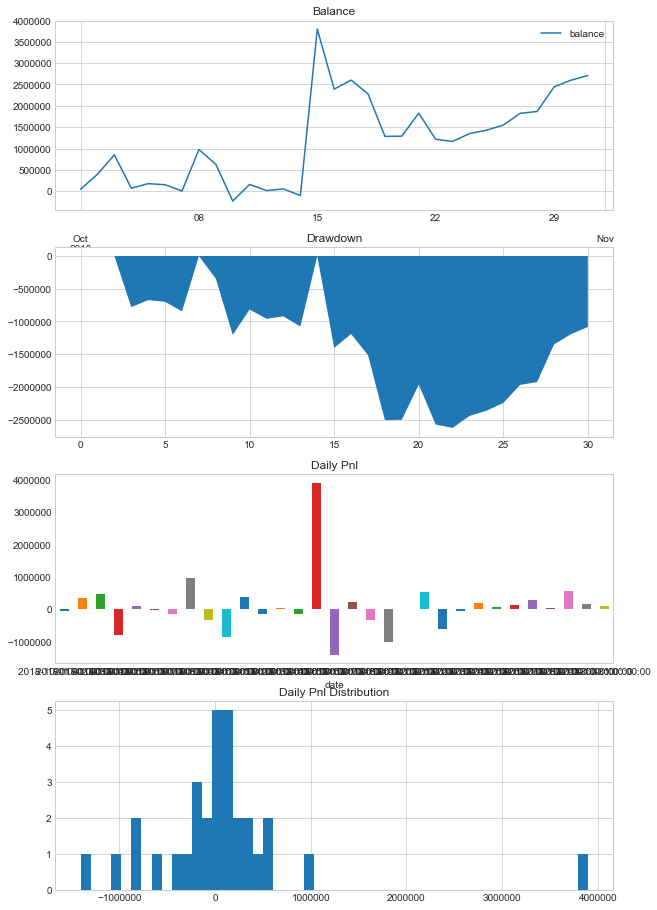

2018-11-15 17:27:52.577746	计算回测结果
2018-11-15 17:27:52.586740	交割单已生成
2018-11-15 17:27:52.586740	------------------------------
2018-11-15 17:27:52.586740	第一笔交易：	2018-10-04 22:30:00
2018-11-15 17:27:52.586740	最后一笔交易：	2018-10-31 15:58:00
2018-11-15 17:27:52.586740	总交易次数：	26
2018-11-15 17:27:52.586740	总盈亏：	2,592,077.89
2018-11-15 17:27:52.586740	最大回撤: 	-807,531.68
2018-11-15 17:27:52.586740	平均每笔盈利：	99,695.3
2018-11-15 17:27:52.586740	平均每笔滑点：	0.0
2018-11-15 17:27:52.586740	平均每笔佣金：	12,855.85
2018-11-15 17:27:52.586740	胜率		42.31%
2018-11-15 17:27:52.586740	盈利交易平均值	314,165.61
2018-11-15 17:27:52.586740	亏损交易平均值	-57,582.92
2018-11-15 17:27:52.586740	盈亏比：	5.46
2018-11-15 17:27:53.246336	策略回测统计图已保存


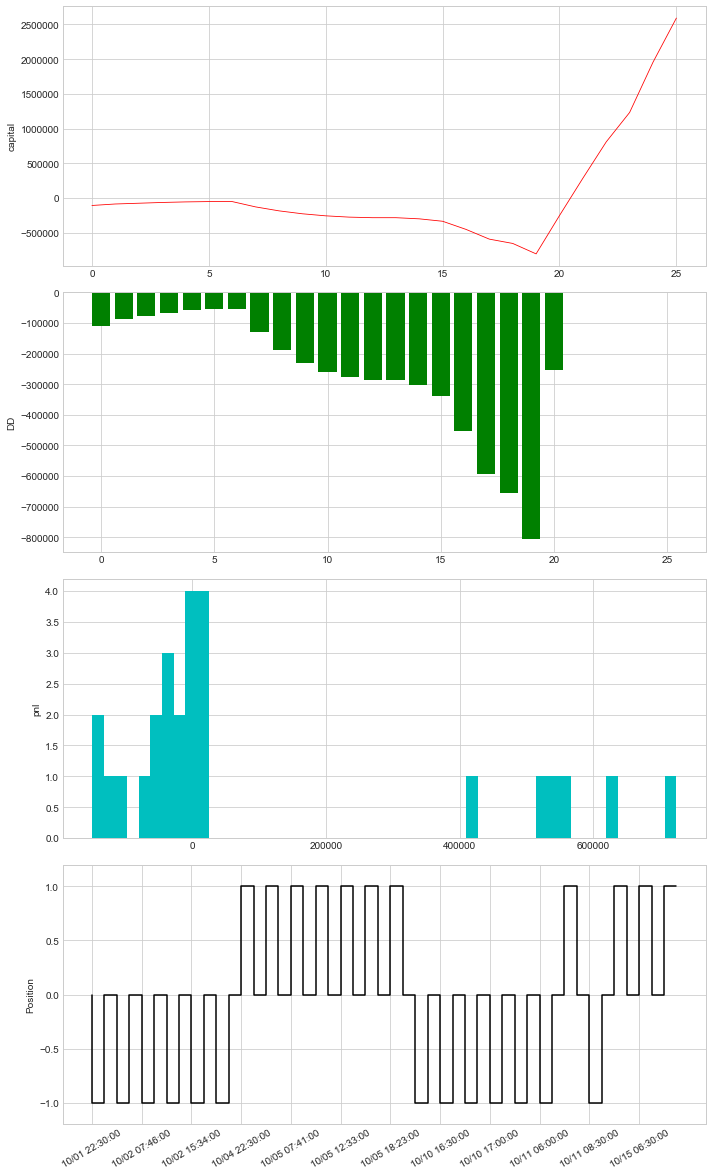

2018-11-15 17:27:53.797042	计算按日统计结果


In [16]:
from vnpy.trader.app.ctaStrategy.ctaBarManager import BacktestingEngine
import pandas as pd

def runBacktesting(strategyClass, settingDict,
                   startDate, endDate, size, slippage, rate):
    engine = BacktestingEngine()
    engine.setBacktestingMode(engine.BAR_MODE)
    engine.setDatabase('VnTrader_1Min_Db')
    engine.setStartDate(startDate, initHours=200)
    engine.setEndDate(endDate)
    engine.setSize(size)
    engine.setSlippage(slippage)
    engine.setRate(rate)
    engine.initStrategy(strategyClass, settingDict)
    engine.setCapital(100000)
    engine.setLog(True, 'E://log//')
    engine.runBacktesting()
    #显示逐日回测结果
    engine.showDailyResult()
    #显示逐笔回测结果
    engine.showBacktestingResult()
    # 计算回测结果
    perfromance = engine.calculateDailyResult()
    perfromanceDf , result = engine.calculateDailyStatistics(perfromance)
    tradeReport = pd.DataFrame([obj.__dict__ for obj in engine.tradeDict.values()])
    tradeDf = tradeReport.set_index('dt')
    return perfromanceDf, tradeDf

if __name__ == '__main__':
    # 同时传入信号与执行的数据
    performanceReport, tradeReport = \
        runBacktesting(DoubleMaStrategy, {'symbolList': ['BTCUSDT:binance']},
                       '20181001 12:00', '20181031 16:00', 100, 0, 5/10000)
    # tradeReport.to_excel('BBandMa5MinStrategyReport.xlsx')

## 绩效报告

In [17]:
tradeReport

,direction,exchange,exchangeOrderID,fee,gatewayName,offset,orderID,orderTime,price,price_avg,rawData,status,symbol,tradeID,tradeTime,volume,vtOrderID,vtSymbol,vtTradeID
dt,,,,,,,,,,,,,,,,,,,
2018-10-01 22:30:00,空,,,0.0,,开仓,1,,6556.00,0.0,None,,,1,2018-10-01 22:30:00,30.0,1,BTCUSDT:binance,1
2018-10-02 06:00:00,空,,,0.0,,开仓,2,,6601.19,0.0,None,,,2,2018-10-02 06:00:00,25.0,2,BTCUSDT:binance,2
2018-10-02 07:46:00,空,,,0.0,,开仓,3,,6598.03,0.0,None,,,3,2018-10-02 07:46:00,20.0,3,BTCUSDT:binance,3
2018-10-02 08:37:00,空,,,0.0,,开仓,4,,6600.00,0.0,None,,,4,2018-10-02 08:37:00,15.0,4,BTCUSDT:binance,4
2018-10-02 15:34:00,空,,,0.0,,开仓,5,,6600.58,0.0,None,,,5,2018-10-02 15:34:00,10.0,5,BTCUSDT:binance,5
2018-10-02 17:00:00,空,,,0.0,,开仓,6,,6602.09,0.0,None,,,6,2018-10-02 17:00:00,5.0,6,BTCUSDT:binance,6
2018-10-04 22:30:00,多,,,0.0,,平仓,7,,6586.00,0.0,None,,,7,2018-10-04 22:30:00,105.0,7,BTCUSDT:binance,7
2018-10-04 22:30:00,多,,,0.0,,开仓,8,,6586.00,0.0,None,,,8,2018-10-04 22:30:00,30.0,8,BTCUSDT:binance,8
2018-10-05 07:41:00,多,,,0.0,,开仓,9,,6583.25,0.0,None,,,9,2018-10-05 07:41:00,25.0,9,BTCUSDT:binance,9
